In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')

In [2]:
STOCK_SYMBOL = 'AAPL'  # Change this to any stock you want
DAYS_BACK = 60  # How many days to look back for prediction

stock_data = yf.download(STOCK_SYMBOL, period='2y')
print(f"Got {len(stock_data)} days of data for {STOCK_SYMBOL}")

prices = stock_data['Close'].values
print(f"Price range: ${prices.min():.2f} to ${prices.max():.2f}")

[*********************100%***********************]  1 of 1 completed

Got 501 days of data for AAPL
Price range: $164.01 to $258.40


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

X_train = []
y_train = []

for i in range(DAYS_BACK, len(scaled_prices)):
    X_train.append(scaled_prices[i-DAYS_BACK:i, 0])  # Past 60 days
    y_train.append(scaled_prices[i, 0])              # Next day

X_train = np.array(X_train)
y_train = np.array(y_train)

In [4]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [5]:
print(f"Training data shape: {X_train.shape}")
print(f"We have {len(X_train)} training examples")

Training data shape: (441, 60, 1)
We have 441 training examples


In [6]:
from sklearn.model_selection import train_test_split

# no shuffle for time series
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# === 3. Train with EarlyStopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.1232 - mae: 0.2603 - val_loss: 0.0199 - val_mae: 0.1143
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0218 - mae: 0.1164 - val_loss: 0.0203 - val_mae: 0.1070
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0119 - mae: 0.0874 - val_loss: 0.0113 - val_mae: 0.0741
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0079 - mae: 0.0702 - val_loss: 0.0106 - val_mae: 0.0746
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0093 - mae: 0.0771 - val_loss: 0.0121 - val_mae: 0.0759
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 0.0077 - mae: 0.0674 - val_loss: 0.0109 - val_mae: 0.0734
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0087 - mae: 0.0746 - val_loss: 0.0105 - val_mae: 0.0731
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0072 - mae: 0.0651 - val_loss: 0.0129 - val_mae: 0.0787
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/

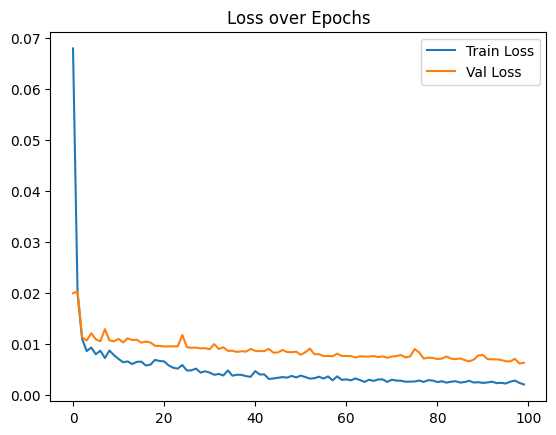

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
MAE: 5.2319
RMSE: 7.4043
R²: 0.7346


In [13]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Predict and inverse scale
y_pred = model.predict(X_val)
y_pred_actual = scaler.inverse_transform(y_pred)
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_val_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_actual))
r2 = r2_score(y_val_actual, y_pred_actual)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


In [14]:
last_60_days = scaled_prices[-DAYS_BACK:]
X_test = []
X_test.append(last_60_days[:, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict next day price
predicted_price_scaled = model.predict(X_test)

# Convert back to actual price
predicted_price = scaler.inverse_transform(predicted_price_scaled)

print(f"Predicted next day price: ${float(predicted_price[0][0]):.2f}")
print(f"Current price: ${float(prices[-1]):.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted next day price: $205.34
Current price: $207.82


In [15]:
future_days = 10
future_predictions = []

current_sequence = last_60_days.copy()

for day in range(future_days):

    X_future = current_sequence.reshape(1, DAYS_BACK, 1)


    next_price = model.predict(X_future, verbose=0)
    future_predictions.append(next_price[0, 0])


    current_sequence = np.append(current_sequence[1:], next_price)


future_predictions = np.array(future_predictions).reshape(-1, 1)
future_prices = scaler.inverse_transform(future_predictions)

print("\n Next 10 days predictions:")
for i, price in enumerate(future_prices):
    print(f"Day {i+1}: ${float(price[0]):.2f}")


 Next 10 days predictions:
Day 1: $205.34
Day 2: $206.46
Day 3: $207.08
Day 4: $207.44
Day 5: $207.69
Day 6: $207.87
Day 7: $208.02
Day 8: $208.15
Day 9: $208.28
Day 10: $208.40
